##  Load metadata data frame and save all text files in list

In [1]:
import pandas as pd
metadf = pd.read_csv('GlassDoorMeta.csv', index_col = 0)

In [2]:
txt_list = []
for i in metadf['id']:
    # use with open
    f = open('job_descriptions/'+str(i)+'.txt', 'r')
    txt = f.read()
    f.close()
    txt_list.append(txt)

## Create TfidfVectorizer instance, apply transformation

In [3]:
from nltk.corpus import stopwords

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(stop_words = stopwords.words('english'))

In [6]:
transformed_txt = v.fit_transform(txt_list)

In [7]:
import numpy as np

X_array = transformed_txt.toarray()

In [10]:
# checking the dimension of the Vectorizer instance
assert len(X_array) == len(metadf)

In [11]:
# create a list of data frames
doc_dfs = []

for counter, doc in enumerate(X_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(v.get_feature_names_out(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    doc_dfs.append(one_doc_as_df)

In [12]:
doc_dfs[1]

,term,score
0,deere,0.455272
1,john,0.274292
2,plan,0.143236
3,benefit,0.140968
4,student,0.124240
...,...,...
16597,ensemble,0.000000
16598,ensembles,0.000000
16599,ensighten,0.000000
16600,ensp,0.000000


## Codebook for Glassdoor Meta Data Frame

In [13]:
metadf.head()

,id,url,company,job_title,duplicates,first_date_scraped,latest_date_scraped,data_science,data_analytics
0,983,/partner/jobListing.htm?pos=213&ao=1110586&s=5...,First Financial Asset Management,Data Analytics Associate of Data Science,288,09-03-2022,09-11-2022,1,1
1,72,/partner/jobListing.htm?pos=203&ao=1110586&s=5...,John Deere,Part-Time Student-Data Analytics-Remote,280,09-03-2022,09-08-2022,1,1
2,1876,/partner/jobListing.htm?pos=206&ao=1110586&s=5...,FrankCrum Staffing,Data Analytics Specialist,258,09-04-2022,09-12-2022,0,1
3,7186,/partner/jobListing.htm?pos=106&ao=1110586&s=5...,Vertex Pharmaceuticals,"Contractor, Data Analytics",246,09-07-2022,09-12-2022,1,1
4,976,/partner/jobListing.htm?pos=206&ao=1110586&s=5...,John Deere,Data Science & Analytics Development Program 2...,214,09-03-2022,09-12-2022,1,0


__id__: An interger as index identifier of one job listing

__url__: The URL (webpage address) of the job listing

__company__: Name of the company posting the job on Glass Door

__job_title__: Title of the job as posted on the webpage

__duplicates__: Number of duplicates of the job, meaning how many times an employer reposted the job descriptions on the website

__first_date_scraped__: The first date that the job was posted

__latest_date_scraped__: The lastest date that the job was posted

__data_science__: A binary of whether the job is categorized as a data science job, with 1 being data science, 0 being not data science

__data_analytics__: A binary of whether the job is categorized as a data analytics job, with 1 being data science, 0 being not data analytics

## Count how many jobs in the corpus match the search queries for "data analytics", "data science", or both

In [14]:
metadf[['data_analytics', 'data_science']].value_counts()

data_analytics  data_science
0               1               415
1               0               381
                1                71
Name: count, dtype: int64

The code cell above implies that there are 415 jobs matched the search query for data science, 381 matched data analytics, and 71 matched both categories.

## Find terms related to database skills

In [15]:
top_matches = [10791, 10803, 2730, 8982, 8115]
indexes = []
for i in top_matches:
    idx = metadf.id[metadf.id == i].index[0]
    indexes.append(idx)

In [16]:
db_terms = []

for i in indexes:
    top_terms = doc_dfs[i].term.tolist()[:31]
    db_terms.append(top_terms)
    
db_df = pd.DataFrame.from_records(db_terms)
db_df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,hrmango,databases,database,bamboo,attitudenice,skillsfearless,featurescollaborate,science1,practicesrequirements,jobdetail,...,sounds,hone,layers,agile,vs,code,architectural,mysql,administrators,aspect
1,developer,sql,haskell,lisp,prolog,retail,julia,ie,qlik,windowing,...,sr,background,experience,bi,junior,query,clients,power,developers,mentoring
2,data,columbus,oh,engineer,geo,spatial,sql,hybrid,please,disparate,...,probabilityproven,crash,engineer5,broadnaxapplicants,preferredfamiliarity,deuntae,scriptingexpertise,countermeasure,formata,oracleexperience
3,technologies,data,cloud,counterparts,sets,batch,limited,ingesting,streaming,azure,...,elt,etl,business,kubernetes,hands,oracle,end,nosql,lifecycle,storage
4,wireless,data,key,include,dish,may,technologies,keep,google,tableau,...,network,transform,radically,new,automation,bitbucket,pulse,allocation,ways,macros


Looking at top job descriptions that are related to databases, I identify the top 30 words with the highest TF-IDF scores to find other words that seem to also relate to database. The five terms I choose, which are top terms and some appear in two or more documents, are: _developer_, _data_, _technologies_, _mssql_, _tableau_.

## Make stacked histograms comparing the "data analytics" jobs to the "data science" jobs (one stacked histogram per word) for the following words: python, knowledge, business, database, dashboards, statistical, and machine.

In [17]:
keywords = ['python', 'knowledge', 'business', 'database', 'dashboards', 'statistical', 'machine']
tfidf_all = {}

for k in keywords:
    tfidf_all[k] = []
    
    for i in doc_dfs:
        # for each get score for python
        this_score = i.loc[i['term'] == k]['score'].iloc[0]
        # append to list
        tfidf_all[k].append(this_score)
    
for k in keywords:
    metadf[k] = tfidf_all[k]

In [18]:
def label_category(row):
    if row['data_science'] == 1 and row['data_analytics'] == 0:
        return 'data science'
    if row['data_science'] == 0 and row['data_analytics'] == 1:
        return 'data analytics'
    if row['data_science'] == 1 and row['data_analytics'] == 1:
        return 'both'
    
metadf['category'] = metadf.apply (lambda row: label_category(row), axis=1)

In [19]:
metadf.head()

,id,url,company,job_title,duplicates,first_date_scraped,latest_date_scraped,data_science,data_analytics,python,knowledge,business,database,dashboards,statistical,machine,category
0,983,/partner/jobListing.htm?pos=213&ao=1110586&s=5...,First Financial Asset Management,Data Analytics Associate of Data Science,288,09-03-2022,09-11-2022,1,1,0.049160,0.000000,0.038954,0.000000,0.000000,0.031573,0.000000,both
1,72,/partner/jobListing.htm?pos=203&ao=1110586&s=5...,John Deere,Part-Time Student-Data Analytics-Remote,280,09-03-2022,09-08-2022,1,1,0.016488,0.033019,0.000000,0.000000,0.000000,0.000000,0.020352,both
2,1876,/partner/jobListing.htm?pos=206&ao=1110586&s=5...,FrankCrum Staffing,Data Analytics Specialist,258,09-04-2022,09-12-2022,0,1,0.000000,0.017931,0.042568,0.000000,0.030657,0.023001,0.000000,data analytics
3,7186,/partner/jobListing.htm?pos=106&ao=1110586&s=5...,Vertex Pharmaceuticals,"Contractor, Data Analytics",246,09-07-2022,09-12-2022,1,1,0.014450,0.043406,0.057250,0.023145,0.000000,0.000000,0.017837,both
4,976,/partner/jobListing.htm?pos=206&ao=1110586&s=5...,John Deere,Data Science & Analytics Development Program 2...,214,09-03-2022,09-12-2022,1,0,0.024316,0.024348,0.038536,0.000000,0.000000,0.031234,0.000000,data science


### Histogram for the term _python_

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: xlabel='python', ylabel='Count'>

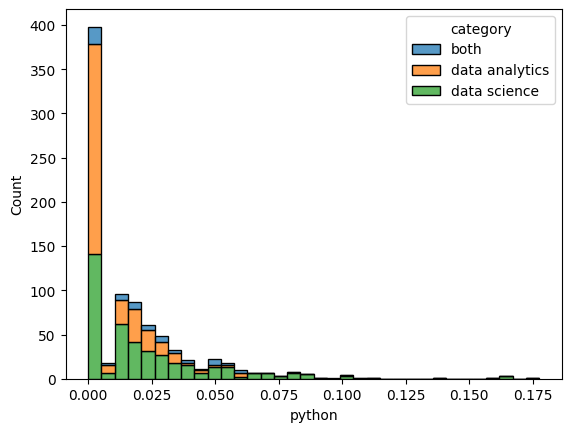

In [21]:
import seaborn as sns
sns.histplot(data=metadf, x='python', hue = 'category', multiple = 'stack')

### Histogram for the term _knowledge_

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: xlabel='knowledge', ylabel='Count'>

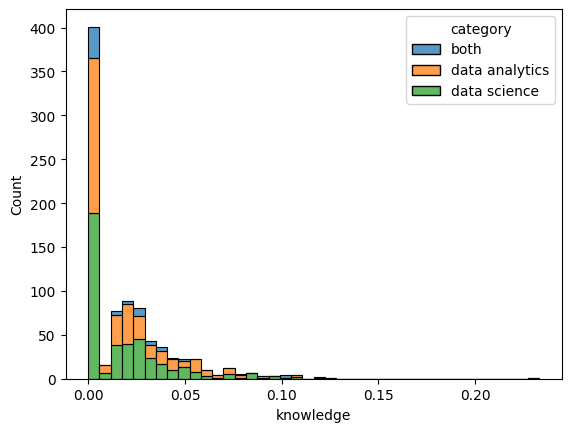

In [22]:
sns.histplot(data=metadf, x='knowledge', hue = 'category', multiple = 'stack')

### Histogram for the term _business_

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: xlabel='business', ylabel='Count'>

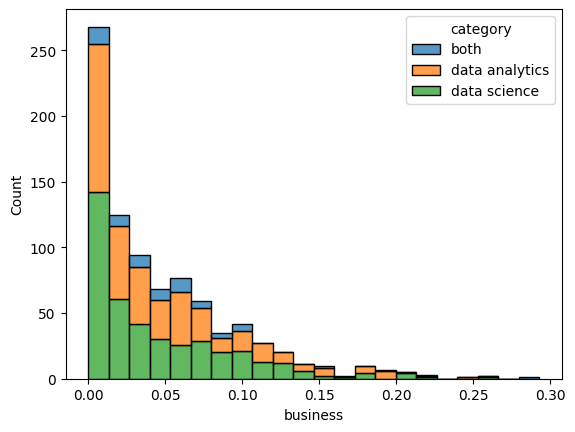

In [23]:
sns.histplot(data=metadf, x='business', hue = 'category', multiple = 'stack')

### Histogram for the term _database_

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: xlabel='database', ylabel='Count'>

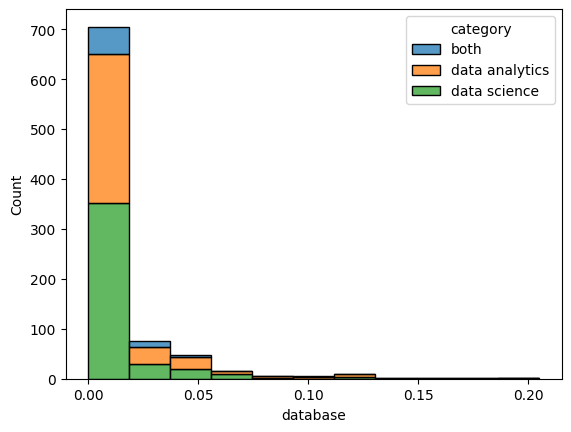

In [24]:
sns.histplot(data=metadf, x='database', hue = 'category', multiple = 'stack')

### Histogram for the term _dashboards_

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: xlabel='dashboards', ylabel='Count'>

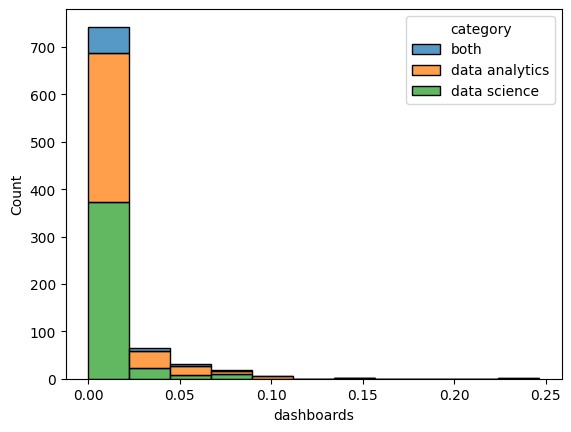

In [25]:
sns.histplot(data=metadf, x='dashboards', hue = 'category', multiple = 'stack')

### Histogram for the term _statistical_

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: xlabel='statistical', ylabel='Count'>

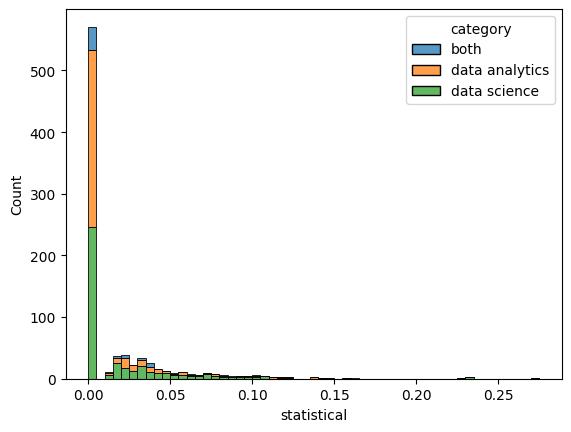

In [26]:
sns.histplot(data=metadf, x='statistical', hue = 'category', multiple = 'stack')

### Histogram for the term _machine_

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: xlabel='machine', ylabel='Count'>

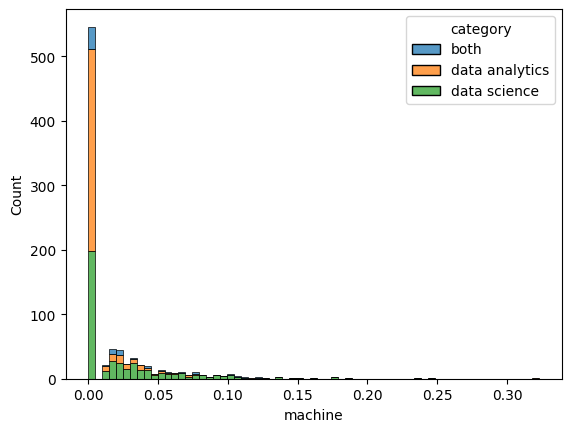

In [27]:
sns.histplot(data=metadf, x='machine', hue = 'category', multiple = 'stack')

#### Histograms are great for visualizing distributions, but they won't help us find the keywords that best separate "data analytics" jobs from "data science" jobs. For that, we need to calculate some kind of score for each key term and then make a ranked list of the terms with the biggest difference. The simplest way to do this is by comparing the mean TF-IDF scores for "data analytics" jobs and "data science" for each word, but means can be deceiving if we have different standard deviations in our samples, so we can normalize with a measure called Cohen's D, which is calculated as | ( mean 1 - mean 2 ) | / SP, where SP equals the pooled standard deviations for the two groups. The result of a Cohen's D test is called an effect size.

In [29]:
def cohen_D(x,y):
    '''
    takes 2 list and return effect size
    '''
    return (np.mean(x) - np.mean(y)) / (sqrt((np.stdev(x) ** 2 + np.stdev(y) ** 2) / 2))

In [30]:
# get lists of index for data science and data analytics job
# does not include both category
ds_index = metadf.index[metadf['category'] == 'data science'].tolist()
da_index = metadf.index[metadf['category'] == 'data analytics'].tolist()

In [31]:
# concatenate all frames for data science
ds_all_dfs = [doc_dfs[i] for i in ds_index]
ds_df = pd.concat(ds_all_dfs)

In [32]:
# concatenate all frames for data analytics
da_all_dfs = [doc_dfs[i] for i in da_index]
da_df = pd.concat(da_all_dfs)

In [33]:
ds_words = ds_df.groupby('term')['score'].apply(list).to_frame()

In [34]:
da_words = da_df.groupby('term')['score'].apply(list).to_frame()

In [35]:
cohend_df = pd.merge(ds_words, da_words, on="term").reset_index()

In [36]:
cohend_df['data_science_mean'] = cohend_df['score_x'].apply(lambda x: np.mean(x))
cohend_df['data_analytics_mean'] = cohend_df['score_y'].apply(lambda x: np.mean(x))

In [37]:
cohend_df['std_ds'] = cohend_df['score_x'].apply(lambda x: np.std(x))
cohend_df['std_da'] = cohend_df['score_y'].apply(lambda x: np.std(x))

In [38]:
def cohen_D(row):
    return (row['data_science_mean'] - row['data_analytics_mean']) / (np.sqrt((row['std_ds'] ** 2 + row['std_da'] ** 2) / 2))

In [39]:
cohend_df['effect_size'] = cohend_df.apply(lambda x: cohen_D(x), axis = 1)

/var/folders/rn/yjyn25416fq_ty8w0zc5f06m0000gn/T/ipykernel_91783/274558904.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (row['data_science_mean'] - row['data_analytics_mean']) / (np.sqrt((row['std_ds'] ** 2 + row['std_da'] ** 2) / 2))


In [40]:
cohend_df.sort_values(by = 'effect_size', ascending = False, inplace= True)
cohend_df.drop(['score_x', 'score_y', 'std_ds', 'std_da'], axis=1, inplace=True)

In [41]:
cohend_df

,term,data_science_mean,data_analytics_mean,effect_size
13350,science,0.050331,0.009172,1.313713
9004,machine,0.026341,0.006302,0.651523
8668,learning,0.032203,0.010571,0.598316
12025,python,0.022995,0.010047,0.554914
13370,scientist,0.017632,0.002573,0.535077
...,...,...,...,...
16509,xperience,0.000000,0.000000,NaN
16512,xray,0.000000,0.000000,NaN
16545,yhlzffgrwd,0.000000,0.000000,NaN
16550,yolo,0.000000,0.000000,NaN


#### Using pandas, make a Data Frame of the various job titles from the ads, with one column for the title, and a second column for the number of ads matching that title. Sort the Data Frame in order of the job ad count, so that the most frequent job title is the first row of the Data Frame. If any job titles are trivially different from one another, merge them into one title. (For example, 'Junior Data Scientist' and 'Jr. Data Scientist' could be merged.)

In [42]:
from Levenshtein import distance as lev

In [43]:
lev('Jr. Data Scientist', 'Junior Data Scientist')

5

In [44]:
df_titles = metadf[['job_title', 'duplicates']]

In [45]:
num_ads = {}
dup = False

# loop through all titles in the df
for i in range(len(df_titles)):
    for k in list(num_ads.keys()):
        # 8 is arbitrary for the distance, the lower the more accurate 2 strings are matched
        if lev(df_titles['job_title'][i], k) <= 8:
            # this only counts duplicates in the meta data frame, not overall duplicates
            # change to += df_titles.loc[df_titles['job_title'][i], 'duplicates'] if count all
            num_ads[k] += 1
            dup = True
            break
    if not dup:
        # add a key-value to dictionary
        num_ads[df_titles['job_title'][i]] = 1
    dup = False

In [46]:
title_dict = {"job_title":[], "num_ads": []}

for key, value in num_ads.items():
    title_dict["job_title"].append(key)
    title_dict["num_ads"].append(value)

title_df = pd.DataFrame(title_dict).sort_values(by = 'num_ads', ascending = False)
title_df

,job_title,num_ads
37,Data Scientist,111
12,AVP Data Analytics,68
7,Data Analytics Manager,31
2,Data Analytics Specialist,20
20,Marketing Data Analyst,18
...,...,...
200,Senior Analyst - Advanced Data Analytics,1
199,Senior Data Analyst - Search Relevancy (100% R...,1
198,"Data Scientist (NY, Seattle or Remote)",1
197,Ph.D. Scientist - R&D,1


#### Using pandas, make a Data Frame of the various companies listing "data analytics" jobs and "data science" jobs, with one column for the company, and a second column for the number of unique job titles matching that company. Sort the Data Frame in order of the job count, so that the most frequent company is the first row of the Data Frame.

In [47]:
df_company = metadf[['company', 'job_title', 'data_science', 'data_analytics']]

In [48]:
df_count = df_company.groupby('company')['job_title'].nunique().to_frame(name='count').reset_index()
df_count.sort_values(by = 'count', ascending=False, inplace=True)
df_count

,company,count
40,Apple,29
234,Insight Global,19
125,CyberCoders,19
489,UnitedHealth Group,13
529,Zillow,9
...,...,...
198,Gradient AI,1
197,Glassdoor,1
194,General Dynamics Information Technology,1
193,GenTech Associates,1


#### Use string methods and/or regular expressions to find salaries and salary ranges in the job ads. Parse the data into some kind of numerical representation (with NAs for ads without salary data) and merge it back with your original metadata Data Frame as one or more columns.

In [49]:
import re

In [50]:
salary_text = []

for txt in txt_list:
    salary = []
    matches = re.findall(r'[\$0-9,\. ]*-[\$0-9,\. ]*', txt.replace(",", ""))
    for m in matches:
        if m.startswith('$'):
            salary.append(m)
    salary_text.append(salary)

In [51]:
metadf['salary'] = [i[0] if len(i) == 1 else 'NA' for i in salary_text]
metadf

,id,url,company,job_title,duplicates,first_date_scraped,latest_date_scraped,data_science,data_analytics,python,knowledge,business,database,dashboards,statistical,machine,category,salary
0,983,/partner/jobListing.htm?pos=213&ao=1110586&s=5...,First Financial Asset Management,Data Analytics Associate of Data Science,288,09-03-2022,09-11-2022,1,1,0.049160,0.000000,0.038954,0.000000,0.000000,0.031573,0.000000,both,NA
1,72,/partner/jobListing.htm?pos=203&ao=1110586&s=5...,John Deere,Part-Time Student-Data Analytics-Remote,280,09-03-2022,09-08-2022,1,1,0.016488,0.033019,0.000000,0.000000,0.000000,0.000000,0.020352,both,NA
2,1876,/partner/jobListing.htm?pos=206&ao=1110586&s=5...,FrankCrum Staffing,Data Analytics Specialist,258,09-04-2022,09-12-2022,0,1,0.000000,0.017931,0.042568,0.000000,0.030657,0.023001,0.000000,data analytics,NA
3,7186,/partner/jobListing.htm?pos=106&ao=1110586&s=5...,Vertex Pharmaceuticals,"Contractor, Data Analytics",246,09-07-2022,09-12-2022,1,1,0.014450,0.043406,0.057250,0.023145,0.000000,0.000000,0.017837,both,NA
4,976,/partner/jobListing.htm?pos=206&ao=1110586&s=5...,John Deere,Data Science & Analytics Development Program 2...,214,09-03-2022,09-12-2022,1,0,0.024316,0.024348,0.038536,0.000000,0.000000,0.031234,0.000000,data science,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,15459,/partner/jobListing.htm?pos=629&ao=1110586&s=5...,firstPRO Inc.,Senior Data Engineering Manager,1,09-11-2022,09-11-2022,0,1,0.000000,0.000000,0.079142,0.000000,0.000000,0.000000,0.000000,data analytics,NA
863,13498,/partner/jobListing.htm?pos=118&ao=1136043&s=5...,iTrending Solutions,Data Analyst,1,09-10-2022,09-10-2022,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,data analytics,NA
864,11707,/partner/jobListing.htm?pos=127&ao=1110586&s=5...,inTulsa,Data Engineer,1,09-09-2022,09-09-2022,0,1,0.033565,0.050414,0.013299,0.026882,0.000000,0.021557,0.000000,data analytics,NA
865,8102,/partner/jobListing.htm?pos=122&ao=1110586&s=5...,inTulsa,Data Scientist,1,09-07-2022,09-07-2022,0,1,0.000000,0.014041,0.055557,0.000000,0.048013,0.000000,0.000000,data analytics,NA
